# PyTorch Simulator

In [53]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import asyncio
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Parameters for the simulation
expected_return = 0.25  # 25% expected return
risk_free_rate = 0.03  # 2.70% risk-free rate
std_deviation = 0.20  # 20% standard deviation
time_horizon = 30  # 10 years
trading_days = 252  # Number of trading days in a year
dt = 1. / trading_days  # Time step for trading days
num_simulations = 1_000_000  # Number of simulations
# Simulate multiple random walks for mutual fund performance using PyTorch matrix operations
time_steps = int(time_horizon * trading_days)
# Define batch size to fit within GPU memory
batch_size = 10_000  # Adjust this value based on your GPU memory capacity

# Set random seed for reproducibility
torch.manual_seed(42)


Using cuda device


In [54]:
import psutil
import gc

# Clean unused memory
gc.collect()
torch.cuda.empty_cache()

# Get the memory usage
memory_info = psutil.virtual_memory()

# Display the memory usage
print(f"Total memory: {memory_info.total / (1024 ** 3):.2f} GB")
print(f"Available memory: {memory_info.available / (1024 ** 3):.2f} GB")
print(f"Used memory: {memory_info.used / (1024 ** 3):.2f} GB")
print(f"Memory usage percentage: {memory_info.percent}%")

# Print GPU memory usage
if device == "cuda":
    gpu_memory_allocated = torch.cuda.memory_allocated(0) / (1024 ** 3)
    gpu_memory_reserved = torch.cuda.memory_reserved(0) / (1024 ** 3)
    gpu_memory_available = (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / (1024 ** 3)
    print(f"Allocated GPU memory: {gpu_memory_allocated:.2f} GB")
    print(f"Reserved GPU memory: {gpu_memory_reserved:.2f} GB")
    print(f"Avalible GPU memory: {gpu_memory_available:.2f} GB")
else:
    print("No GPU available")

Total memory: 376.55 GB
Available memory: 323.81 GB
Used memory: 48.59 GB
Memory usage percentage: 14.0%
Allocated GPU memory: 0.00 GB
Reserved GPU memory: 0.00 GB
Avalible GPU memory: 15.74 GB


In [55]:
# Initialize an empty list to store the price matrices
price_matrices = []
devices = []
final_prices = []  # Convert to numpy for visualization

# Distribute computing balance to two GPUs if available

if torch.cuda.device_count() > 1:
    devices.append(torch.device('cuda:0'))
    devices.append(torch.device('cuda:1'))
else:
    devices.append(torch.device('cuda:0'))

# Generate random normal returns for all simulations in batches and move to the GPU
idx = 0
for i in range(0, num_simulations, batch_size):
    current_batch_size = min(batch_size, num_simulations - i)
    returns_matrix = torch.normal(
        mean=(expected_return - risk_free_rate) * dt, 
        std=std_deviation * torch.sqrt(torch.tensor(dt)),
        size=(current_batch_size, time_steps)
    ).to(devices[idx % len(devices)])
    idx += 1
    # Calculate cumulative returns and convert to mutual fund prices
    
    price_matrix_batch =  torch.exp(torch.cumsum(returns_matrix, dim=1))
    
    final_prices.append(price_matrix_batch[:, -1].cpu().numpy())  # Convert to numpy for visualization
    # Clean unused memory
    torch.cuda.empty_cache()
final_prices = np.concatenate(final_prices)


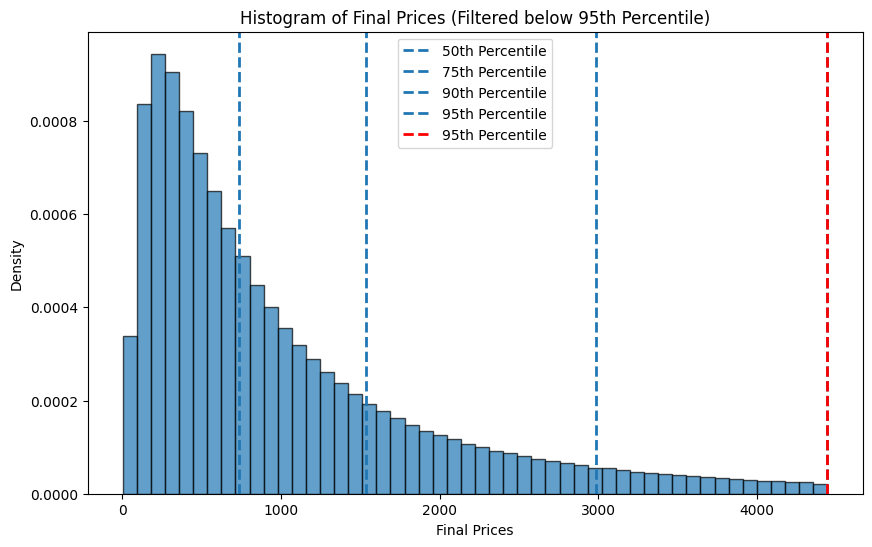

In [74]:
# Plotting the histogram of final returns with percentages
# plt.figure(figsize=(10, 6))
# Calculate the 90th percentile of final prices
percentile_95 = np.percentile(final_prices, 95)

# Filter final prices to include only those below the 90th percentile
filtered_final_prices = final_prices[final_prices <= percentile_95]

# Plot the histogram of the filtered final prices
plt.figure(figsize=(10, 6))

counts, bins, patches = plt.hist(filtered_final_prices, bins=50, edgecolor='black', alpha=0.7, density=True)

# Calculate and draw percentiles
percentiles = [50, 75, 90, 95]
for percentile in percentiles:
    value = np.percentile(final_prices, percentile)
    plt.axvline(value, linestyle='dashed', linewidth=2, label=f'{percentile}th Percentile')

# Add legend
plt.legend()
# Draw histogram with the percentile
plt.axvline(percentile_95, color='r', linestyle='dashed', linewidth=2, label='95th Percentile')
plt.xlabel('Final Prices')
plt.ylabel('Density')
plt.title('Histogram of Final Prices (Filtered below 95th Percentile)')
plt.legend()
plt.show()